In [1]:
import subprocess
try:
  import dgl
except:
  subprocess.check_call(["python", '-m', 'pip', 'install', 'dgl-cu110'])
  import dgl

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [ ]:
import os
import dgl.data
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import tqdm
from sklearn.linear_model import LinearRegression
from dgl.data.utils import save_graphs
from dgl.data.utils import load_graphs
from dgl.nn.pytorch.conv import ChebConv
import copy
import matplotlib.pyplot as plt

In [ ]:
os.chdir("/content/drive/MyDrive/Winter_Research")

In [ ]:
max_pixs = 128309

## Make the Dataset

In [ ]:
CA_x, CA_y = [], []
KS_x, KS_y = [], []
MT_x, MT_y = [], []
TX_x, TX_y = [], []
OH_x, OH_y = [], []
states = {"CA" : [CA_x, CA_y, "Roi_1"],
         "KS" : [KS_x, KS_y, "Roi_2"],
         "MT" : [MT_x, MT_y, "Roi_3"],
         "TX" : [TX_x, TX_y, "Roi_4"],
         "OH" : [OH_x, OH_y, "Roi_5"]}

#### Load into RAM

In [ ]:
master_df = pd.read_csv("Sentinel2_Traffic/Traffic_Data/5_state_traffic.csv")
master_df = master_df.set_index("Unnamed: 0")
CA_x, CA_y = [], []
KS_x, KS_y = [], []
MT_x, MT_y = [], []
TX_x, TX_y = [], []
OH_x, OH_y = [], []
states = {"Cali" : [CA_x, CA_y, "Roi_1"],
         "KS" : [KS_x, KS_y, "Roi_2"],
         "MT" : [MT_x, MT_y, "Roi_3"],
         "TX" : [TX_x, TX_y, "Roi_4"],
         "Ohio" : [OH_x, OH_y, "Roi_5"]}
j = 0
for st in ["Cali", "KS", "MT", "TX", "Ohio"]:
# for st in ["TX"]:
  # path_check = "R/" + states[st][2] + "/greedy_a/"
  path = "new_roi/" + st # + "/sent_cloud_90p_raw/"
  # imgs_check = os.listdir(path_check)
  imgs = os.listdir(path)
  # for img, img_check in zip(imgs, imgs_check):
  for img in imgs:
    date = img[len(st):len(st) + 10]
    # print(date)
    # break
    try:
      photo = pd.read_csv(path + '/' + img)
    except:
      continue
    # photo_check = np.loadtxt(path_check + img_check).reshape(-1, 7, 3)
#       cali_pixs = 72264 #
# kansas_pixs = 69071 #
# mont_pixs = 72099 #
# texas_pixs = 71764
# ohio_pixs = 62827
    if  photo.shape[0] < 50000:
      continue
    if date in list(master_df.index):
      if st == "Cali":
        lookup_st = "CA"
      elif st == "Ohio":
        lookup_st = "OH"
      else:
        lookup_st = st
      if not pd.isna(master_df.loc[date][lookup_st]):
        states[st][0].append(photo)
        states[st][1].append(master_df.loc[date][lookup_st])
      print(j, st, photo.shape)
      j += 1

0 Cali (67690, 7)
1 Cali (52888, 7)
2 Cali (70689, 7)
3 Cali (70162, 7)
4 Cali (71523, 7)
5 Cali (71058, 7)
6 Cali (61338, 7)
7 Cali (70828, 7)
8 Cali (69707, 7)
9 Cali (69819, 7)
10 Cali (118378, 7)
11 Cali (68459, 7)
12 Cali (71375, 7)
13 Cali (70410, 7)
14 Cali (118378, 7)
15 Cali (70102, 7)
16 Cali (118378, 7)
17 Cali (70043, 7)
18 Cali (69951, 7)
19 Cali (117484, 7)
20 Cali (69912, 7)
21 Cali (118378, 7)
22 Cali (69639, 7)
23 Cali (70370, 7)
24 Cali (118378, 7)
25 Cali (71215, 7)
26 Cali (71215, 7)
27 Cali (113338, 7)
28 Cali (71335, 7)
29 Cali (95720, 7)
30 Cali (113977, 7)
31 Cali (52690, 7)
32 Cali (69626, 7)
33 Cali (52084, 7)
34 Cali (117246, 7)
35 Cali (117797, 7)
36 Cali (109498, 7)
37 Cali (70828, 7)
38 Cali (70881, 7)
39 Cali (70787, 7)
40 Cali (61416, 7)
41 Cali (69661, 7)
42 Cali (63068, 7)
43 Cali (106988, 7)
44 Cali (69716, 7)
45 Cali (118378, 7)
46 Cali (70917, 7)
47 Cali (118378, 7)
48 Cali (71335, 7)
49 Cali (69906, 7)
50 Cali (70827, 7)
51 Cali (111410, 7)
52 Cali

In [ ]:
def gen_around(x, y):
  return [(x, y), (x, y + 10), (x, y - 10), (x + 10, y), (x - 10, y), (x + 10, y + 10), (x + 10, y - 10), (x - 10, y + 10), (x - 10, y - 10)]

def gen_around_strict(x, y):
  return [(x, y), (x, y + 10), (x, y - 10), (x + 10, y), (x - 10, y)]

def neighbors(road, coords, x, y, diagonal=True):
  neigh = []
  if diagonal:
    cand = gen_around(x, y)
  else:
    cand = gen_around_strict(x, y)
  for pix in cand:
    if pix[0] in coords:
      if pix[1] in coords[pix[0]]:
        neigh.append(coords[pix[0]][pix[1]]['idx'])
  return neigh

def src_dst(road, coords, diagonal=True):
  src, dst, values = [],  [] , []
  for row in range(road.shape[0]):
    x = road["x"][row]
    y = road["y"][row]
    idx = coords[x][y]['idx']
    val = coords[x][y]['val']
    # if val[0] != road[row][:3][0]:
    #   assert(False)
    for c in neighbors(road, coords, x, y, diagonal):
      src.append(idx)
      dst.append(c)
      values.append(val)
  return src, dst #, values

In [ ]:
device = torch.cuda.current_device()

In [ ]:
class RoadDataset(DGLDataset):
  def __init__(self, states):
    self.states = states
    super().__init__(name='road_graphs')

  def process(self):
    self.graphs = []
    self.labels = []
    self.state = []
    for st in self.states.keys():
    # for st in ["TX"]:
      print(st)
      for i in range(len(self.states[st][0])):
        print(i)
        img = states[st][0][i]
        coords = {}
        vals = []
        print(img.shape[0])
        for j in range(img.shape[0]):
          # print(img[j].shape)
          lon = img["x"][j].astype(int)
          # print(lon)
          lat = img["y"][j].astype(int)
          val = [img["B2"][j], img["B3"][j], img["B4"][j]]
          vals.append(val)
          if lon not in coords:
            coords[lon] = {}
          coords[lon][lat] = {'idx' : j, 'val' : val}
        src, dst = src_dst(img, coords)
        #src, dst, values = src_dst(img, coords)
        # print(np.mean(src), np.mean(dst), np.mean(values))
        graph = dgl.graph((src, dst), num_nodes=img.shape[0])
        graph.ndata['feat'] = torch.from_numpy(np.array(vals))
        #graph = graph.add_self_loop(graph)
        graph = graph.to(device)
        self.graphs.append(graph)
        self.labels.append(self.states[st][1][i])
        self.state.append(st)
        # assert(False)

  def __getitem__(self, i):
      return self.graphs[i], self.labels[i], self.state[i]

  def __len__(self):
      return len(self.graphs)


In [ ]:
class RoadDatasetLoad(DGLDataset):
  def __init__(self, states):
    self.states = states
    super().__init__(name='road_graphs')

  def process(self):
    self.graphs = load_graphs("graphs/data_new.bin")[0]
    self.labels = np.loadtxt("graphs/labels_new.csv")
    self.state = np.loadtxt("graphs/states_new.csv", dtype=np.str)


  def __getitem__(self, i):
      return self.graphs[i], self.labels[i]#, self.state[i]

  def __len__(self):
      return len(self.graphs)

In [ ]:
Road_Graphs = RoadDataset(states)

In [ ]:
dataset = Road_Graphs

In [ ]:
dataset[100]

(Graph(num_nodes=118378, num_edges=963178,
       ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}
       edata_schemes={}), 1586.0, 'Cali')

In [ ]:
# Road_Graphs = RoadDataset(states)
save_graphs('graphs/data_new.bin', dataset.graphs)
labels = np.array(dataset.labels)
states = np.array(dataset.state)
np.savetxt("graphs/labels_new.csv", labels)
np.savetxt('graphs/states_new.csv', states, fmt="%s")

In [ ]:
Road_Load = RoadDatasetLoad(states)

In [ ]:
dataset_save = dataset

In [ ]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
# dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)
dataset = Road_Load

## Train the Model

In [ ]:
# X = dataset[:][0]
# y = dataset[:][1]

In [ ]:
print(dataset.state[0:37])
print(dataset.state[37:64])
print(dataset.state[64:88])
print(dataset.state[88:119])
print(dataset.state[119:124])

In [ ]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [ ]:
state_val = False
one_sample = False
state = "TX"
lookup_state = {"CA" : 0, "KS" : 1, "MT" : 2, "TX" : 3, "OH" : 4}
state_idxs = [(0, 37), (37, 64), (64, 88), (88, 119), (119, 124)]

In [ ]:
num_examples = len(dataset)
if state_val:
  x = torch.arange(num_examples)
  start = state_idxs[lookup_state[state]][0]
  end = state_idxs[lookup_state[state]][1]
  test_sample = x[start + 3: end]
  val_sample = x[start : start + 3]
  train_sample = torch.cat((x[:start], x[end:]))
  train_sample = train_sample[torch.randperm(train_sample.shape[0])]
  print(train_sample)
else:
  num_train = int(num_examples * 0.7)
  num_val = int(num_examples * 0.85)
  x = torch.randperm(num_examples)
  train_sample = x[:num_train]
  val_sample = x[num_train: num_val]
  test_sample = x[num_val:]

train_sampler = SubsetRandomSampler(train_sample)
val_sampler = SubsetRandomSampler(val_sample)
test_sampler = SubsetRandomSampler(test_sample)

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler,  batch_size=16, drop_last=False)
val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler,  batch_size=16, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=16, drop_last=False)

In [ ]:
# print(train_sample, val_sample, test_sample)

In [ ]:
it = iter(test_dataloader)

In [ ]:
batch = next(it)
print(batch)
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print('The original graphs in the minibatch:')
print(graphs)
print(labels)

[Graph(num_nodes=1391195, num_edges=11304515,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}
      edata_schemes={}), tensor([1965., 1639., 3670.,  826., 3139., 2746., 2037.,  590., 1769.,  484.,
        2131.,  311.,  934., 2246., 2940., 2316.], dtype=torch.float64)]
Number of nodes for each graph element in the batch: tensor([ 69951,  63068,  69906, 127224,  52690, 118378,  66583,  70803, 118378,
         84674,  70549,  84389,  92248, 113370,  70606, 118378])
Number of edges for each graph element in the batch: tensor([ 571747,  514596,  571380, 1029080,  429136,  963178,  542709,  572075,
         963178,  683436,  576661,  677637,  750020,  919372,  577132,  963178])
The original graphs in the minibatch:
[Graph(num_nodes=69951, num_edges=571747,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=63068, num_edges=514596,
      ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}
      edata_sche

In [ ]:
from dgl.nn import GraphConv, DenseGraphConv, GATConv

class GCN(nn.Module):
    def __init__(self, in_feats, conv_hidden, lin_hidden):
        super(GCN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.LR = nn.LeakyReLU(0.2)
        self.lin_layers = nn.ModuleList()
        self.conv_layers.append(GraphConv(in_feats, conv_hidden[0]))
        for i in range(1, len(conv_hidden)):
          self.conv_layers.append(GraphConv(conv_hidden[i - 1], conv_hidden[i]))
        for i in range(1, len(lin_hidden) - 1):
          self.lin_layers.append(nn.Linear(lin_hidden[i - 1], lin_hidden[i]))
          #self.lin_layers.append(nn.BatchNorm1d(lin_hidden[i]))
        self.lin_layers.append(nn.Linear(lin_hidden[-2], lin_hidden[-1]))
        

    def forward(self, g, in_feat):
        output = in_feat
        for layer in self.conv_layers:
          output = self.LR(layer(g, output))
          # print(torch.mean(output))
        graphs = dgl.unbatch(g)
        flat_arr = torch.zeros((g.batch_size, max_pixs))
        prev = 0
        # print("Before", torch.mean(output))
        for i in range(len(batched_graph.batch_num_nodes())):
          end = prev + int(batched_graph.batch_num_nodes()[i].item())
          entry = output[prev: end]
          entry = entry / int(g.batch_num_nodes()[i].item())
          pad_val = int(torch.mean(entry).item())
          pad_length = (max_pixs - entry.shape[0]) // 2
          entry = torch.nn.functional.pad(entry.flatten(), (pad_length, pad_length), value=pad_val)
          flat_arr[i][:entry.shape[0]] = entry
          prev = end
        flat_arr = flat_arr.to(device)
        #print("After", torch.mean(flat_arr))
        output = flat_arr
        for i, layer in enumerate(self.lin_layers):
          output = layer(output)
          if i != (len(self.lin_layers) - 1):
            output = self.LR(output)
        #print(flat_arr.shape)
        # g.ndata['h'] = h
        # print(dgl.mean_nodes(g, 'h'))
        # assert(False)
        return output #dgl.mean_nodes(g, 'h')

In [ ]:
# # Create the model with given dimensions
model = GCN(3, [10, 10, 1], [max_pixs,1000, 500, 100, 50, 10, 1])
# model = GCN(3, 16, 1)
model.cuda()
criterion = nn.MSELoss()
#model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
del criterion
del optimizer
del model
torch.cuda.empty_cache()

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


GCN(
  (conv_layers): ModuleList(
    (0): GraphConv(in=3, out=10, normalization=both, activation=None)
    (1): GraphConv(in=10, out=10, normalization=both, activation=None)
    (2): GraphConv(in=10, out=1, normalization=both, activation=None)
  )
  (LR): LeakyReLU(negative_slope=0.2)
  (lin_layers): ModuleList(
    (0): Linear(in_features=118378, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
best_model = model
min_val = 1e9

In [ ]:
j = 0
for epoch in range(100):
  loss_tot = 0
  loss = 0
  batches = 0
  model.train()
  for batched_graph, labels in train_dataloader:
    batched_graph = batched_graph.to(device)
    labels = labels.to(device)
    pred = model(batched_graph, batched_graph.ndata['feat'].float()) 
    # print(pred, labels)
    labels = labels.to(device)
    loss = criterion(pred, labels.reshape(labels.shape[0], 1).float())
    loss_tot += loss.item()
    batches += 1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if j % 10 == 0:
    print("Train Loss:", loss_tot / batches)
  num_tests = 0
  loss_i = 0
  with torch.no_grad():
    model.eval()
    for batched_graph, labels in val_dataloader:
      batched_graph = batched_graph.to(device)
      labels = labels.to(device)
      pred = model(batched_graph, batched_graph.ndata['feat'].float())
      loss_i += criterion(pred, labels.reshape(labels.shape[0], 1).float()).item()
    # x.extend([x[0] for x in pred.cpu().detach().numpy().tolist()])
    # y.extend([x[0] for x in labels.reshape(labels.shape[0], 1).cpu().detach().numpy().tolist()])
    # print(type(pred))
      num_tests += 1
    val_loss = loss_i / num_tests
    if j % 10 == 0:
      print('Val loss:', val_loss)
    # val_loss.append(loss_v.item())
    if val_loss < min_val:
      print("new_best:", val_loss)
      min_val = val_loss
      best_model = copy.deepcopy(model)
    j += 1

Train Loss: 76757.93666992188
Val loss: 694629.7125
Train Loss: 12493.833142089843
Val loss: 768211.99375
Train Loss: 8094.956567382813
Val loss: 809729.95
Train Loss: 58567.025073242185
Val loss: 682895.2
Train Loss: 6346.937719726562
Val loss: 677687.85
Train Loss: 6815.377615356445
Val loss: 633869.85625
Train Loss: 2691.4429260253905
Val loss: 727192.43125
Train Loss: 2097.0757019042967
Val loss: 683974.8625
Train Loss: 1544.1816467285157
Val loss: 667326.5125
Train Loss: 1331830.2625
Val loss: 1113972.8125


In [ ]:
# num_correct = 0
num_tests = 0
x = []
y = []
loss = 0
with torch.no_grad():
  for batched_graph, labels in test_dataloader:
      # print(batched_graph)
      batched_graph = batched_graph.to(device)
      labels = labels.to(device)
      pred = best_model(batched_graph, batched_graph.ndata['feat'].float())
      loss += criterion(pred, labels.reshape(labels.shape[0], 1).float()).item()
      x.extend([x[0] for x in pred.cpu().detach().numpy().tolist()])
      y.extend([x[0] for x in labels.reshape(labels.shape[0], 1).cpu().detach().numpy().tolist()])
      num_tests += 1

print('Test loss:', loss / num_tests)

Test loss: 543203.75625


0.4706106732383747


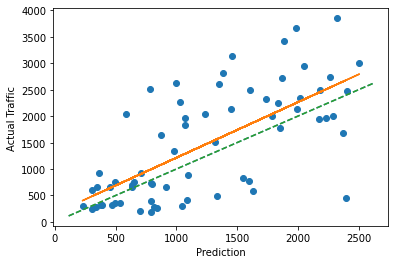

In [ ]:
x_temp = y
y_temp = x
# print(y_temp)
# for i in range(len(y_temp)):
#   if y_temp[i] < 600:
#     y_temp.pop(i)
#     x_temp.pop(i)
#     break
x_plot = np.array(y_temp)
y_plot = np.array(x_temp)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
pre_y = fit.predict(new_x)
# plt.plot
plt.plot(new_x, pre_y)
plt.plot(x_vals, y_vals, '--')
# plt.savefig("GCN_MSE_143_r_881.png")
plt.show()

In [ ]:
y

In [ ]:
labels

tensor([0, 0, 0, 1, 0])

In [ ]:
class ChebNet(nn.Module):
    def __init__(self,
                 k,
                 in_feats,
                 hiddens,
                 out_feats):
        super(ChebNet, self).__init__()
        self.pool = nn.MaxPool1d(2)
        self.layers = nn.ModuleList()
        self.readout = MaxPooling()

        # Input layer
        self.layers.append(
            ChebConv(in_feats, hiddens[0], k))

        for i in range(1, len(hiddens)):
            self.layers.append(
                ChebConv(hiddens[i - 1], hiddens[i], k))

        self.cls = nn.Sequential(
            nn.Linear(hiddens[-1], out_feats),
            nn.LogSoftmax()
        )

    def forward(self, g_arr, feat):
        for g, layer in zip(g_arr, self.layers):
            feat = self.pool(layer(g, feat, [2] * g.batch_size).transpose(-1, -2).unsqueeze(0))\
                .squeeze(0).transpose(-1, -2)
        return self.cls(self.readout(g_arr[-1], feat))